# 🧠 Neural Networks for HyperFaaS Resource Prediction

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import yaml
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../models/neural')
sys.path.append('../../src/models')

from neural_networks import SimpleNeuralNetwork, DeepNeuralNetwork

plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 📊 1. Data Preparation

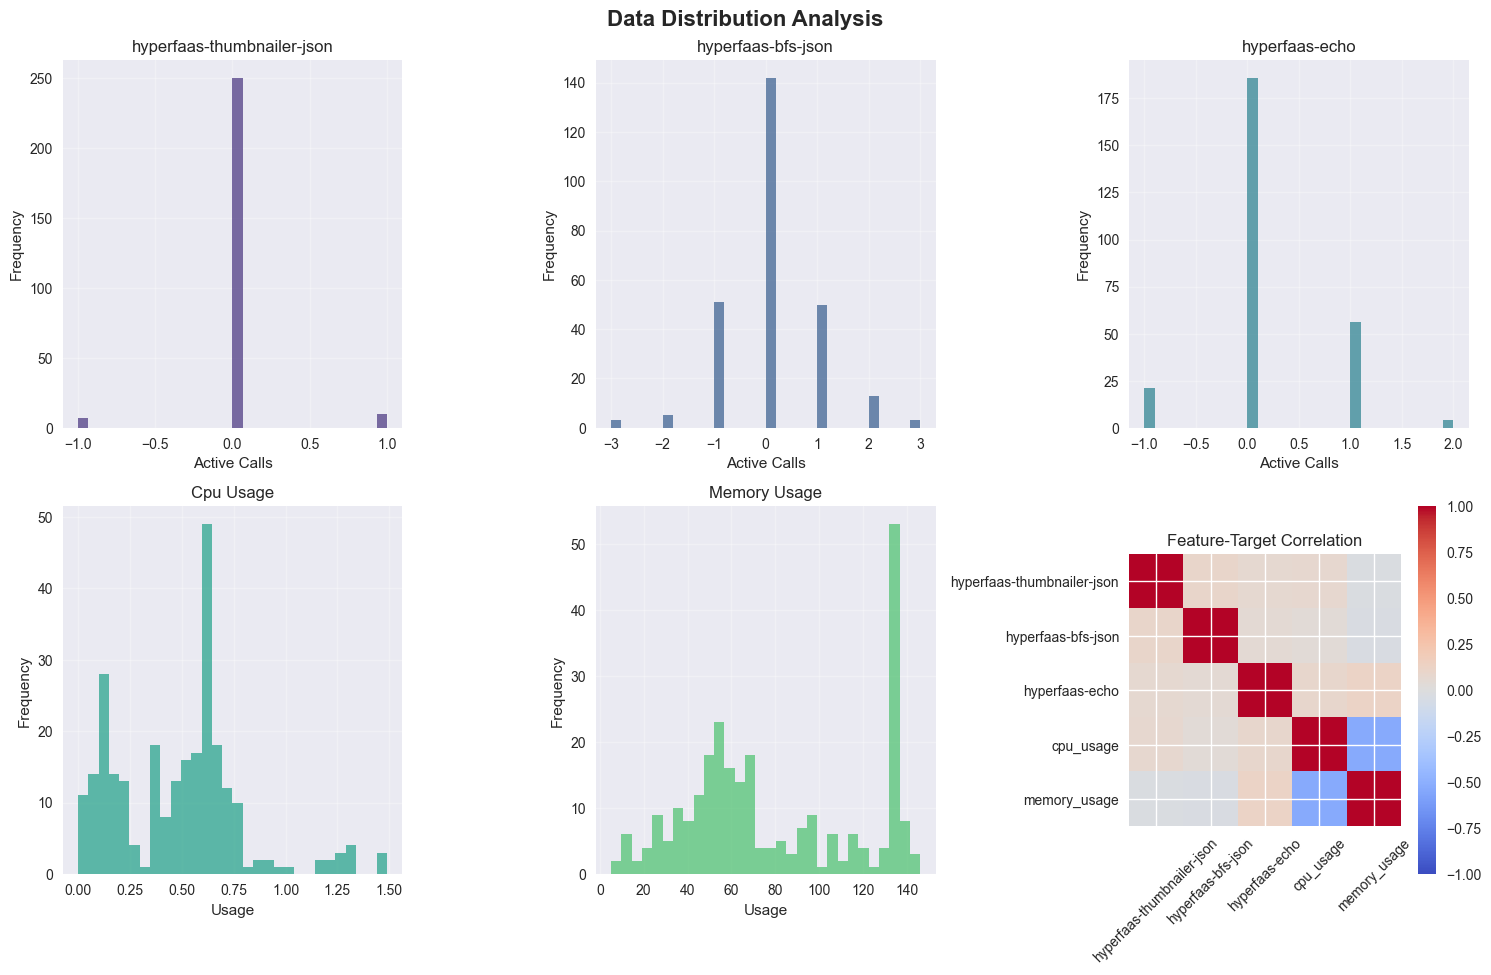

In [62]:
df = pd.read_csv('../../data/processed/training.csv')

feature_columns = [
    'hyperfaas-thumbnailer-json:latest_active_calls',
    'hyperfaas-bfs-json:latest_active_calls', 
    'hyperfaas-echo:latest_active_calls'
]
target_columns = ['cpu_usage', 'memory_usage']

X = df[feature_columns].values
y = df[target_columns].values

X = np.nan_to_num(X, nan=0.0)
y = np.nan_to_num(y, nan=0.0)


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Data Distribution Analysis', fontsize=16, fontweight='bold')


for i, col in enumerate(feature_columns):
    axes[0, i].hist(X[:, i], bins=30, alpha=0.7, color=f'C{i}')
    axes[0, i].set_title(f'{col.split(":")[0]}')
    axes[0, i].set_xlabel('Active Calls')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)


for i, col in enumerate(target_columns):
    axes[1, i].hist(y[:, i], bins=30, alpha=0.7, color=f'C{i+3}')
    axes[1, i].set_title(f'{col.replace("_", " ").title()}')
    axes[1, i].set_xlabel('Usage')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].grid(True, alpha=0.3)


corr_data = np.column_stack([X, y])
corr_matrix = np.corrcoef(corr_data.T)
im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 2].set_title('Feature-Target Correlation')
all_labels = [col.split(':')[0] for col in feature_columns] + target_columns
axes[1, 2].set_xticks(range(len(all_labels)))
axes[1, 2].set_yticks(range(len(all_labels)))
axes[1, 2].set_xticklabels(all_labels, rotation=45)
axes[1, 2].set_yticklabels(all_labels)
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.show()

In [63]:
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Scale features and targets (important for neural networks)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Validation set: {X_val_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")
print(f"\nFeatures: mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
print(f"Targets: mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")

Training set: 186 samples
Validation set: 27 samples
Test set: 54 samples

Features: mean=-0.0000, std=1.0000
Targets: mean=0.0000, std=1.0000


## 🤖 3. Train Neural Network Models

In [64]:
# Model configurations
model_configs = {
    'simple_neural_network': {
        'type': 'neural',
        'hyperparameters': {
            'input_size': X_train_scaled.shape[1],
            'output_size': y_train_scaled.shape[1],
            'hidden_size': 64,
            'learning_rate': 0.001,
            'epochs': 100,
            'batch_size': 32
        }
    },
    'deep_neural_network': {
        'type': 'neural',
        'hyperparameters': {
            'input_size': X_train_scaled.shape[1],
            'output_size': y_train_scaled.shape[1],
            'hidden_sizes': [128, 64, 32],
            'dropout_rate': 0.2,
            'learning_rate': 0.001,
            'epochs': 150,
            'batch_size': 32
        }
    },
}

model_classes = {
    'simple_neural_network': SimpleNeuralNetwork,
    'deep_neural_network': DeepNeuralNetwork,
}

In [65]:
# Train feedforward networks (Simple and Deep)
feedforward_models = ['simple_neural_network', 'deep_neural_network']
trained_models = {}
training_histories = {}

for model_name in feedforward_models:
    print(f"\n🏋️ Training {model_name.replace('_', ' ').title()}...")
    
    # Create and configure model
    config = model_configs[model_name]
    model = model_classes[model_name](config)
    model.feature_names = feature_columns
    model.target_names = target_columns
    
    # Train model
    history = model.train(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
    
    # Store results
    trained_models[model_name] = model
    training_histories[model_name] = history
    
    print(f"  ✓ Training completed! Final loss: {history['val_loss'][-1]:.6f}")
    print(f"  ✓ Epochs trained: {len(history['train_loss'])}")

print("\n🎉 Feedforward networks trained successfully!")


🏋️ Training Simple Neural Network...
  ✓ Training completed! Final loss: 0.846293
  ✓ Epochs trained: 100

🏋️ Training Deep Neural Network...
  ✓ Training completed! Final loss: 0.892361
  ✓ Epochs trained: 150

🎉 Feedforward networks trained successfully!


## 📈 4. Training Curves Analysis

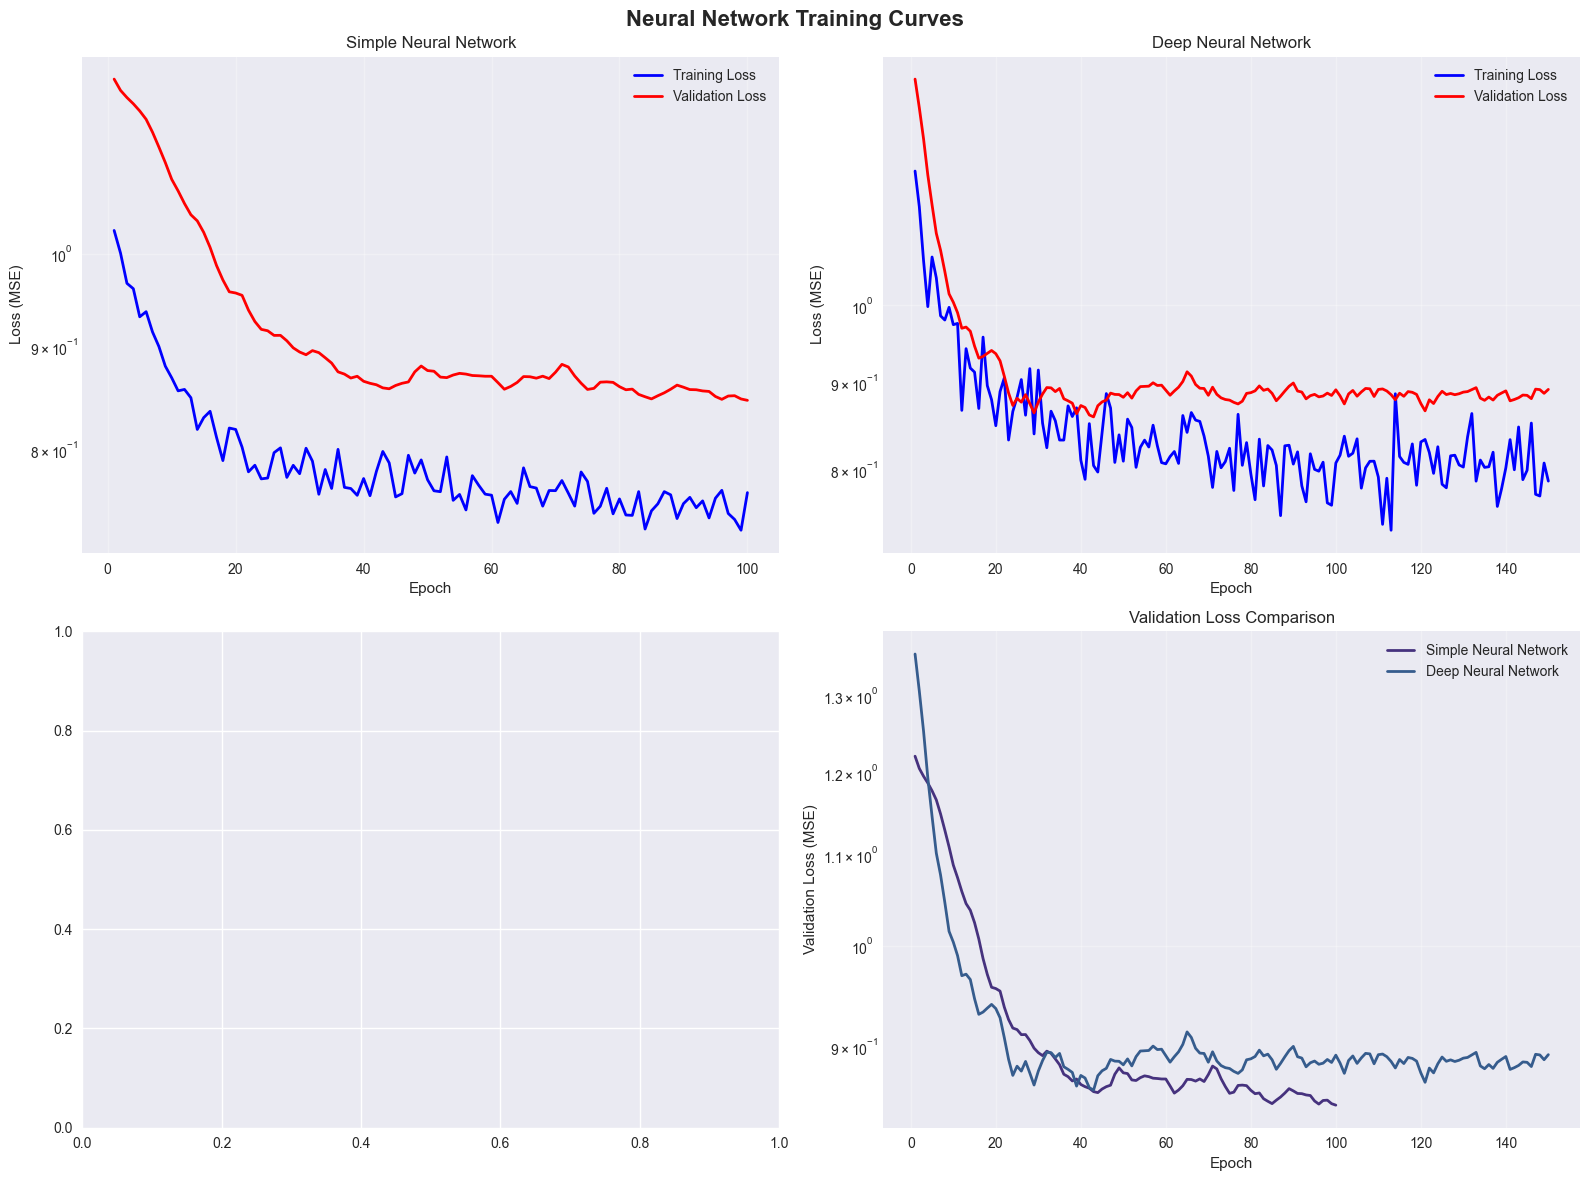

In [66]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Neural Network Training Curves', fontsize=16, fontweight='bold')

# Individual model curves
for i, (model_name, history) in enumerate(training_histories.items()):
    if i < 3:
        row, col = i // 2, i % 2
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        axes[row, col].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
        axes[row, col].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        
        axes[row, col].set_title(f'{model_name.replace("_", " ").title()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel('Loss (MSE)')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_yscale('log')

# Comparison plot
axes[1, 1].set_title('Validation Loss Comparison')
for model_name, history in training_histories.items():
    epochs = range(1, len(history['val_loss']) + 1)
    axes[1, 1].plot(epochs, history['val_loss'], label=model_name.replace('_', ' ').title(), linewidth=2)

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss (MSE)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

In [67]:
# Convergence analysis
print("🎯 Training Convergence Analysis:")
print("=" * 60)

for model_name, history in training_histories.items():
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Final losses
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    
    # Best validation loss
    best_val_loss = min(val_loss)
    best_epoch = val_loss.index(best_val_loss) + 1
    
    # Overfitting check (validation loss increases while training decreases)
    overfitting_ratio = final_val_loss / final_train_loss
    
    print(f"\n📊 {model_name.replace('_', ' ').title()}:")
    print(f"  Final Training Loss: {final_train_loss:.6f}")
    print(f"  Final Validation Loss: {final_val_loss:.6f}")
    print(f"  Best Validation Loss: {best_val_loss:.6f} (epoch {best_epoch})")
    print(f"  Overfitting Ratio: {overfitting_ratio:.2f}")
    if overfitting_ratio > 1.5:
        print(f"  ⚠️  Potential overfitting detected!")
    else:
        print(f"  ✅ Good generalization")

🎯 Training Convergence Analysis:

📊 Simple Neural Network:
  Final Training Loss: 0.761797
  Final Validation Loss: 0.846293
  Best Validation Loss: 0.846293 (epoch 100)
  Overfitting Ratio: 1.11
  ✅ Good generalization

📊 Deep Neural Network:
  Final Training Loss: 0.788122
  Final Validation Loss: 0.892361
  Best Validation Loss: 0.859737 (epoch 43)
  Overfitting Ratio: 1.13
  ✅ Good generalization


## 🎯 5. Prediction Visualizations

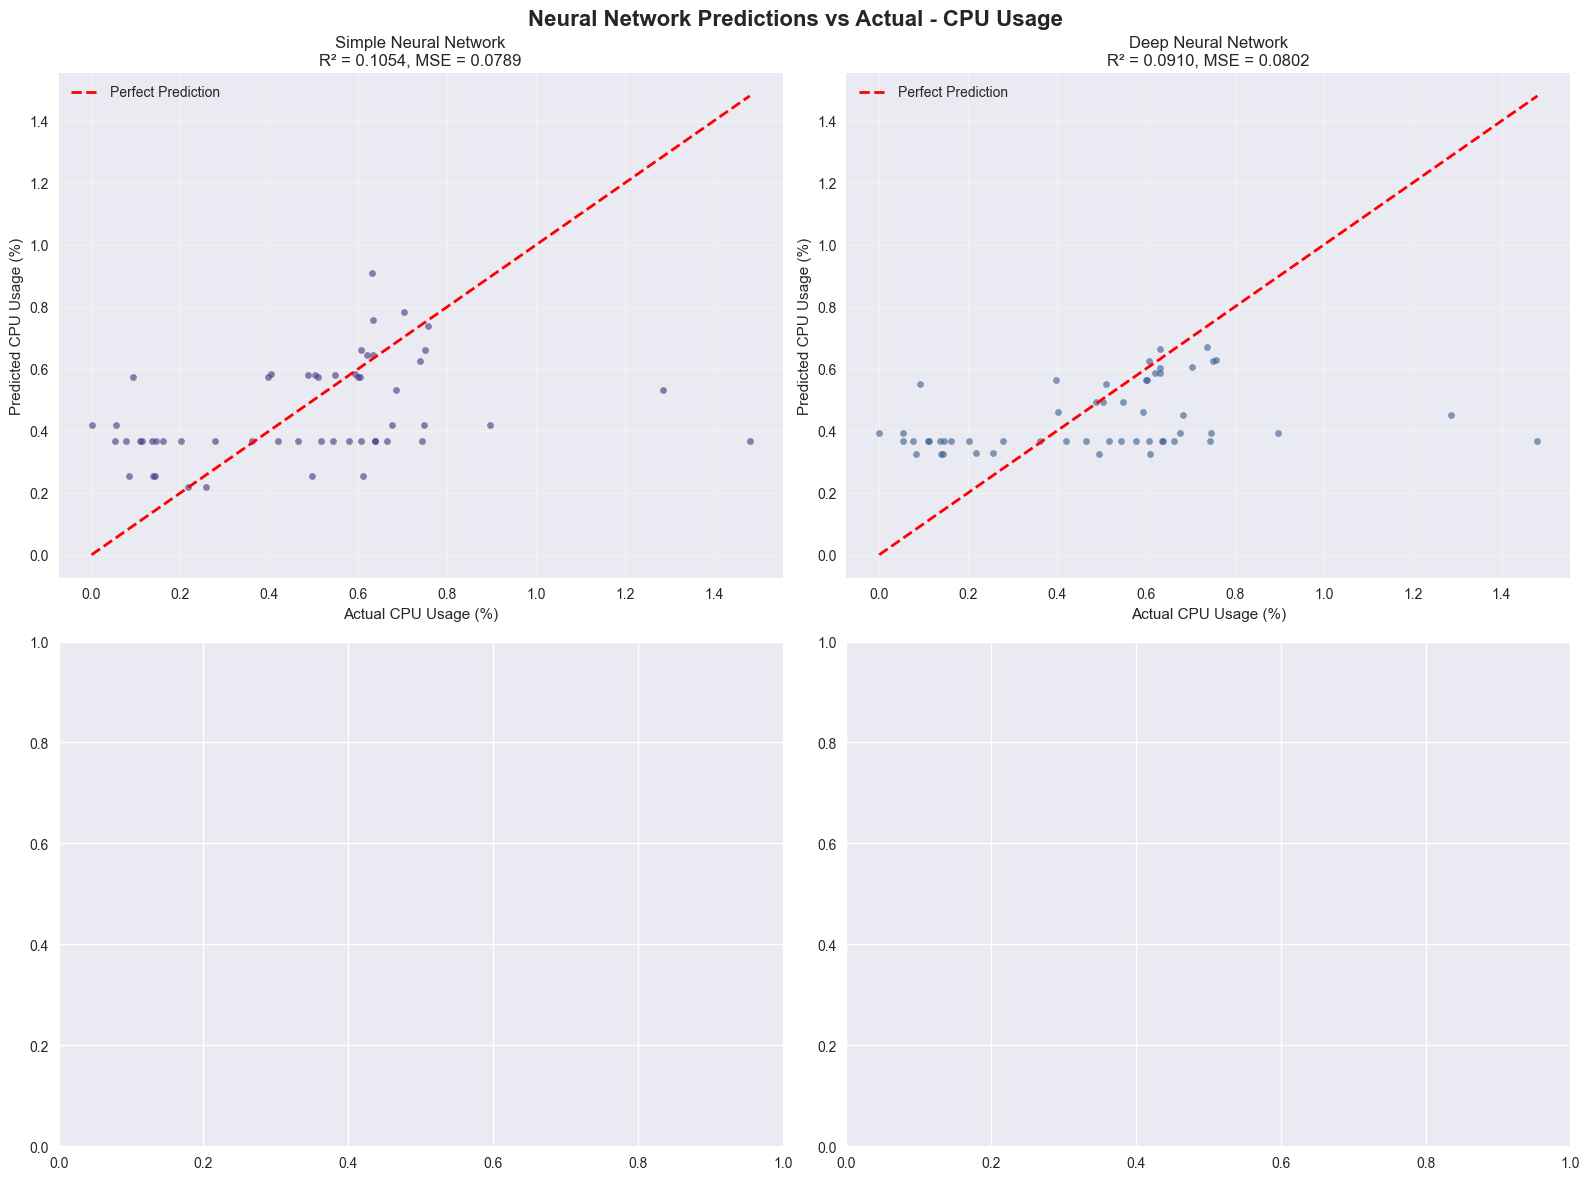

In [68]:
# CPU usage predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Neural Network Predictions vs Actual - CPU Usage', fontsize=16, fontweight='bold')

model_names = list(evaluation_results.keys())
for i, model_name in enumerate(model_names):
    row, col = i // 2, i % 2
    
    results = evaluation_results[model_name]
    actual_cpu = results['actual'][:, 0]
    predicted_cpu = results['predictions'][:, 0]
    
    # Scatter plot
    axes[row, col].scatter(actual_cpu, predicted_cpu, alpha=0.6, s=20, color=f'C{i}')
    
    # Perfect prediction line
    min_val = min(actual_cpu.min(), predicted_cpu.min())
    max_val = max(actual_cpu.max(), predicted_cpu.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = results['test_metrics'].get('r2_cpu', 0)
    mse = mean_squared_error(actual_cpu, predicted_cpu)
    
    axes[row, col].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}, MSE = {mse:.4f}')
    axes[row, col].set_xlabel('Actual CPU Usage (%)')
    axes[row, col].set_ylabel('Predicted CPU Usage (%)')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot if we have 3 models
if len(model_names) == 3:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

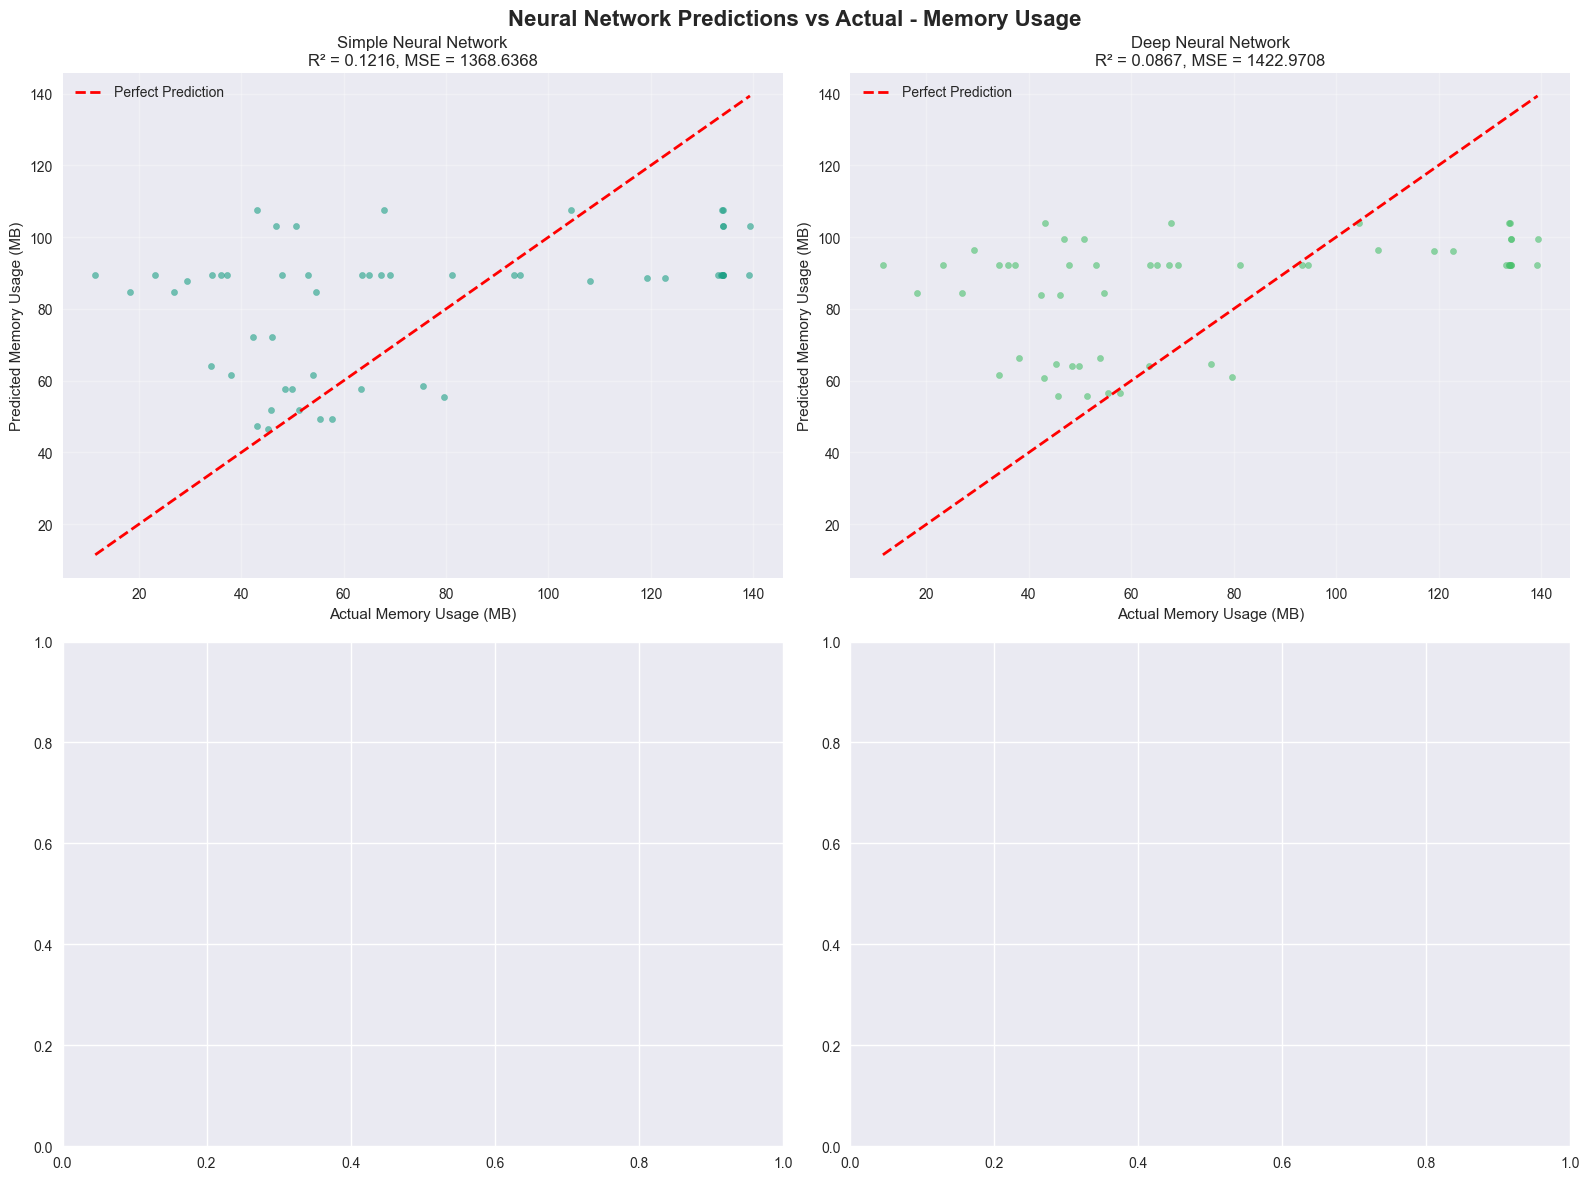

In [69]:
# Memory usage predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Neural Network Predictions vs Actual - Memory Usage', fontsize=16, fontweight='bold')

for i, model_name in enumerate(model_names):
    row, col = i // 2, i % 2
    
    results = evaluation_results[model_name]
    actual_memory = results['actual'][:, 1]
    predicted_memory = results['predictions'][:, 1]
    
    # Scatter plot
    axes[row, col].scatter(actual_memory, predicted_memory, alpha=0.6, s=20, color=f'C{i+3}')
    
    # Perfect prediction line
    min_val = min(actual_memory.min(), predicted_memory.min())
    max_val = max(actual_memory.max(), predicted_memory.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = results['test_metrics'].get('r2_memory', 0)
    mse = mean_squared_error(actual_memory, predicted_memory)
    
    axes[row, col].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}, MSE = {mse:.4f}')
    axes[row, col].set_xlabel('Actual Memory Usage (MB)')
    axes[row, col].set_ylabel('Predicted Memory Usage (MB)')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot if we have 3 models
if len(model_names) == 3:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()